In [1]:
#Installs Needed
#!pip install opencv-python
#!pip install pillow
#os.getcwd()

In [1]:
import os
import concurrent.futures
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from tensorflow.keras.utils import to_categorical
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, f1_score
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Sequential, load_model
from keras.metrics import Precision, Recall, AUC
from keras.callbacks import ReduceLROnPlateau

print("Booting...")

Booting...


In [2]:
# Path to Image Folder
image_folder = "semantic_drone_dataset/training_set/images"
image_label_folder = "semantic_drone_dataset/training_set/gt/semantic/label_images"
csv_file_path = 'semantic_drone_dataset/training_set/gt/semantic/class_dict.csv'

# Create an empty list to store the loaded images
images = []
label_images = []

# Set the target size to which you want to resize the images
target_size = (600, 400)  # Resize OG Image Size: (6000,1000)

In [3]:
def load_and_process_image(filename, folder, file_extension):
    # Check if the file has the correct extension
    if filename.lower().endswith(file_extension):  
        image_path = os.path.join(folder, filename)
        with Image.open(image_path) as image:
            resized_image = image.resize(target_size, Image.NEAREST)
            return np.array(resized_image)
    else:
        return None  

In [4]:
# Function to load images using multiple threads
def load_images_concurrently(folder_path, file_extension):
    with concurrent.futures.ThreadPoolExecutor() as executor:

        all_files = os.listdir(folder_path)

        processed_images = list(executor.map(load_and_process_image, all_files, [folder_path]*len(all_files), [file_extension]*len(all_files)))

        return [image for image in processed_images if image is not None]

# Load images using threads
images = load_images_concurrently(image_folder, '.jpg')

# Load label images using threads
label_images = load_images_concurrently(image_label_folder, '.png')

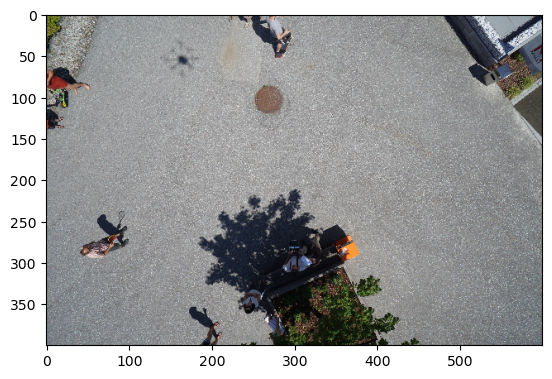

Image size: (400, 600, 3)


In [5]:
# Display the first image
if images:
    plt.imshow(images[0])
    plt.axis()
    plt.show()
    
    # Print the size of the image
    image_size = images[0].shape
    print("Image size:", image_size)

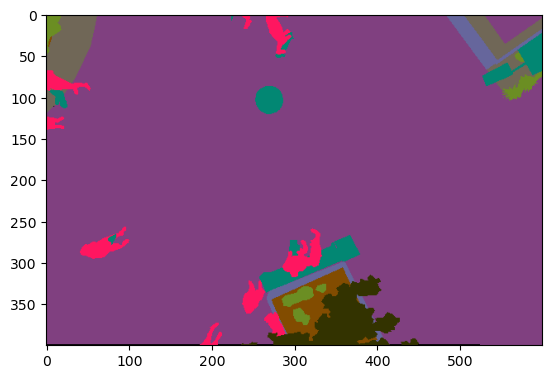

Image size: (400, 600, 3)


In [6]:
# Display the first label image
if label_images:
    plt.imshow(label_images[0])
    plt.show()
    
    # Print the size of the image
    image_size = label_images[0].shape
    print("Image size:", image_size)

In [10]:
# Load class definitions from the class_dict.csv
class_df = pd.read_csv(csv_file_path, index_col=False, skipinitialspace=True)

# Map class names to RGB values
class_dict = {tuple(row[['r', 'g', 'b']].values): row['name'] for _, row in class_df.iterrows()}

# Extract label codes and names
label_codes = [tuple(row[['r', 'g', 'b']].values) for _, row in class_df.iterrows()]
label_names = [class_dict.get(rgb, 'Unknown') for rgb in label_codes]
length_of_label_codes = len(label_codes)
print("# of Labels: ", length_of_label_codes)

# of Labels:  24


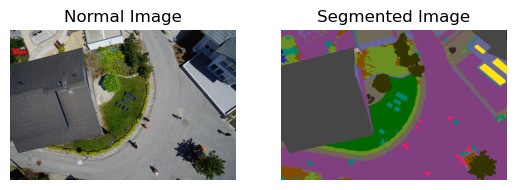

In [11]:
#Pre-process Data
normal_images = []
segmented_images = []
num_classes = length_of_label_codes;
num_images_to_process = 598
input_shape_var = (400, 600, 3)

normal_images = np.array(images[:num_images_to_process])
segmented_images = np.array(label_images[:num_images_to_process])

# Split the data into training and validation sets
split_ratio = 0.8
split = int(split_ratio * len(normal_images))

train_images, test_images = normal_images[:split], normal_images[split:]
train_labels, test_labels = segmented_images[:split], segmented_images[split:]

# Randomly select and visualize one pair of images
random_index = np.random.randint(len(train_images))

x = train_images[random_index]
y = train_labels[random_index]

# Plot the normal image
plt.subplot(1, 2, 1)
plt.imshow(x)
plt.title("Normal Image")
plt.axis("off")

# Plot the segmented image
plt.subplot(1, 2, 2)
plt.imshow(y)
plt.title("Segmented Image")
plt.axis("off")

plt.show()

In [12]:
# Create a mapping from RGB values to integer identifiers
rgb_to_id_mapping = {tuple(code): i for i, code in enumerate(label_codes)}

# Print the mapping for verification
print("RGB to ID Mapping:", rgb_to_id_mapping)

# Convert RGB images to integer labels
train_labels_int = np.zeros_like(train_labels[:, :, :, 0], dtype=np.uint8)
test_labels_int = np.zeros_like(test_labels[:, :, :, 0], dtype=np.uint8)

for i in range(num_classes):
    mask_train = np.all(train_labels == label_codes[i], axis=-1)
    mask_test = np.all(test_labels == label_codes[i], axis=-1)

    train_labels_int[mask_train] = i
    test_labels_int[mask_test] = i

# Apply one-hot encoding
train_labels_one_hot = np.eye(num_classes)[train_labels_int]
test_labels_one_hot = np.eye(num_classes)[test_labels_int]

# Print the shape of the one-hot encoded labels
print("Shape of one-hot encoded train labels:", train_labels_one_hot.shape)
# Print the shape of the one-hot encoded labels
print("Shape of one-hot encoded test labels:", test_labels_one_hot.shape)

# Print a small portion of the one-hot encoded labels for verification
#print("One-Hot Encoded Labels (a small portion):")
#print(train_labels_one_hot[:5, :5, :])

RGB to ID Mapping: {(0, 0, 0): 0, (128, 64, 128): 1, (130, 76, 0): 2, (0, 102, 0): 3, (112, 103, 87): 4, (28, 42, 168): 5, (48, 41, 30): 6, (0, 50, 89): 7, (107, 142, 35): 8, (70, 70, 70): 9, (102, 102, 156): 10, (254, 228, 12): 11, (254, 148, 12): 12, (190, 153, 153): 13, (153, 153, 153): 14, (255, 22, 96): 15, (102, 51, 0): 16, (9, 143, 150): 17, (119, 11, 32): 18, (51, 51, 0): 19, (190, 250, 190): 20, (112, 150, 146): 21, (2, 135, 115): 22, (255, 0, 0): 23}
Shape of one-hot encoded train labels: (320, 400, 600, 24)
Shape of one-hot encoded test labels: (80, 400, 600, 24)


In [13]:
from keras.layers import Input, concatenate
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=input_shape_var, padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout layer
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),  # Add dropout layer
    
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),
    Dropout(0.25),  # Add dropout layer
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    UpSampling2D((2, 2)),
    Dropout(0.25),  # Add dropout layer
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    
    Conv2D(num_classes, (3, 3), activation='softmax', padding='same')
])

input_layer = Input(shape=input_shape_var)
conv1 = Conv2D(64, 3, activation='relu', padding='same')(input_layer)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

up3 = UpSampling2D(size=(2, 2))(conv2)
up3 = concatenate([conv1, up3], axis=-1)
conv3 = Conv2D(64, 3, activation='relu', padding='same')(up3)
conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)

outputs = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(conv3)

model = keras.Model(inputs=input_layer, outputs=outputs)

# Print model summary
model.summary()

print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels_one_hot.shape)
print("Validation images shape:", test_images.shape)
print("Validation labels shape:", test_labels_one_hot.shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 400, 600, 3)]        0         []                            
                                                                                                  
 conv2d_11 (Conv2D)          (None, 400, 600, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization_10 (Ba  (None, 400, 600, 64)         256       ['conv2d_11[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_12 (Conv2D)          (None, 400, 600, 64)         36928     ['batch_normalization_10[0

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

In [15]:
# Create an instance of ImageDataGenerator with desired augmentations
datagen = ImageDataGenerator(
    # Specify your desired augmentation parameters
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,  
    brightness_range=[0.5, 1.5]
)

In [16]:
class_weights = {
    0: 1.0, 1: 0.8, 2: 1.0, 3: 1.2, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.2, 8: 1.1, 9: 1.0,
    10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0, 14: 1.1, 15: 5.0, 16: 1.0, 17: 1.0, 18: 1.0,
    19: 1.2, 20: 1.0, 21: 1.0, 22: 1.0
}


batch_size = 2
num_epochs = 10

# Create generators for training and validation data
train_generator = datagen.flow(train_images, train_labels_one_hot, batch_size=batch_size, shuffle=True)
validation_generator = datagen.flow(test_images, test_labels_one_hot, batch_size=batch_size, shuffle=False)

# Define callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with class weights using the generator
history = model.fit(
    train_generator,
    epochs=num_epochs,
    steps_per_epoch=len(train_images) // batch_size,  # Adjust based on the size of your dataset
    validation_data=validation_generator,
    validation_steps=len(test_images) // batch_size,  # Adjust based on the size of your dataset
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
160/160 [==============================] - 696s 4s/step - loss: 4.2200 - accuracy: 0.2583 - precision: 0.1735 - recall: 0.0013 - auc: 0.7337 - val_loss: 2.2746 - val_accuracy: 0.4014 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8586 - lr: 0.0010
Epoch 2/10
160/160 [==============================] - 689s 4s/step - loss: 3.4187 - accuracy: 0.3376 - precision: 0.2704 - recall: 0.0054 - auc: 0.8673 - val_loss: 2.0937 - val_accuracy: 0.3548 - val_precision: 1.0000 - val_recall: 1.0417e-07 - val_auc: 0.8880 - lr: 0.0010
Epoch 3/10
160/160 [==============================] - 684s 4s/step - loss: 3.4168 - accuracy: 0.3401 - precision: 0.4398 - recall: 0.0075 - auc: 0.8672 - val_loss: 2.0335 - val_accuracy: 0.4390 - val_precision: 0.3066 - val_recall: 0.0210 - val_auc: 0.8882 - lr: 0.0010
Epoch 4/10
160/160 [==============================] - 684s 4s/step - loss: 3.3988 - accuracy: 0.3422 - precision: 0.3355 - recall: 0.0051 - auc: 0.8684 - val_loss: 2.2354 - val_a

In [15]:
# You can save the model if needed
#model.save('semantic_segmentation_model.h5')
model.save('semantic_segmentation_model_three.keras')


In [17]:
# Evaluate on test data
predictions = model.predict(test_images)

# Convert predictions and ground truth to integer labels
predicted_labels = np.argmax(predictions, axis=-1)
true_labels = np.argmax(test_labels_one_hot, axis=-1)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(true_labels.flatten(), predicted_labels.flatten(), average=None, zero_division=1)
recall = recall_score(true_labels.flatten(), predicted_labels.flatten(), average=None, zero_division=1)
f1 = f1_score(true_labels.flatten(), predicted_labels.flatten(), average=None, zero_division=1)
print(len(precision), len(recall), len(f1))
for i in range(np.max(true_labels) + 1):
    if i < len(precision) and i < len(recall) and i < len(f1):
        print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}")
# Print metrics for each class
#for i in range(np.max(true_labels) + 1):
    #print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1 Score: {f1[i]}")

# Print history for debugging
print("Training History:", history.history)

3/3 [==============================] - 35s 7s/step
24 24 24
Class 0 - Precision: 0.10869565217391304, Recall: 0.00018617813523979745, F1 Score: 0.0003717195747528065
Class 1 - Precision: 0.045978148718746024, Recall: 0.00042547442098267717, F1 Score: 0.000843146499360966
Class 2 - Precision: 0.020499108734402853, Recall: 4.579018935238736e-05, F1 Score: 9.137626561093972e-05
Class 3 - Precision: 0.44061310556624916, Recall: 0.13911198995502372, F1 Score: 0.21146079888250988
Class 4 - Precision: 0.0, Recall: 0.0, F1 Score: 1.0
Class 5 - Precision: 0.023606370875995448, Recall: 0.001031216027333437, F1 Score: 0.0019761081383513784
Class 6 - Precision: 0.0, Recall: 0.0, F1 Score: 1.0
Class 7 - Precision: 0.04849483358126913, Recall: 0.3558044971846473, F1 Score: 0.08535596557010788
Class 8 - Precision: 0.03385103577051764, Recall: 0.32499316513044835, F1 Score: 0.06131549697825945
Class 9 - Precision: 1.0, Recall: 0.0, F1 Score: 0.0
Class 10 - Precision: 0.061100969692261885, Recall: 0.05

In [ ]:
# Example of evaluating the model on training data
train_predictions = model.predict(train_images)


 9/10 [==========================>...] - ETA: 12s

In [ ]:

# Choose a random sample index for visualization
sample_index = np.random.randint(0, len(train_images))

# Get the model's prediction on the chosen image
prediction = model.predict(np.expand_dims(train_images[sample_index], axis=0))

# Normalize prediction values between 0 and 1
normalized_prediction = prediction / np.max(prediction)

# Create a custom colormap
custom_cmap = ListedColormap(['black', 'red', 'green', 'blue', 'purple', 'yellow', 'cyan', 'orange', 'brown', 'pink', 'gray', 'lightgreen', 'lightblue', 'lightcoral', 'lightyellow', 'lightcyan', 'lightpink', 'lightgray', 'darkred', 'darkgreen', 'darkblue', (0.4, 0, 0.6), (0.6, 0.6, 0), 'darkcyan'])

# Visualize the original segmented image (Ground Truth)
plt.imshow(np.argmax(train_labels_one_hot[sample_index], axis=-1),cmap='viridis')
plt.title("Ground Truth")
plt.show()

# Visualize the normalized model's prediction using the custom colormap
plt.imshow(np.argmax(normalized_prediction[0], axis=-1), cmap='viridis')
plt.title("Model Prediction")
plt.show()

# Visualize the normal image
plt.imshow(train_images[sample_index])
plt.title("Normal Image")
plt.show()

